# **FLOWER CLASSIFICATION**


We use the dataset from [this source](https://www.kaggle.com/alxmamaev/flowers-recognition) to classify images of flowers into one of the defined 5 categories.

In [1]:
# !kill -9 -1

#Mount the drive into Google Colab environment
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
'''
Check to see GPU allocation on Colab
'''

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Running setup.py bdist_wheel for gputil ... - done
  Stored in directory: /root/.cache/pip/wheels/17/0f/04/b79c006972335e35472c0b835ed52bfc0815258d409f560108
Successfully built gputil
  Running setup.py bdist_wheel for humanize ... - done
  Stored in directory: /root/.cache/pip/wheels/69/86/6c/f8b8593bc273ec4b0c653d3827f7482bb2001a2781a73b7f44
Successfully built humanize
Gen RAM Free: 12.7 GB  | Proc size: 138.6 MB
GPU RAM Free: 11439MB | Used: 0MB | Util   0% | Total 11439MB


In [2]:
'''
perform necessary imports
'''

import numpy as np
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="3"
import cv2
# import tensorflow_gpu as tf
import keras
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
# import pydot
from matplotlib.pyplot import imshow
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.models import model_from_json
from PIL import Image
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from keras.preprocessing.image import ImageDataGenerator
import random
import seaborn as sns
from keras.optimizers import SGD, Adam

import matplotlib.image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


## Read and save input data

In [0]:
#function for preprocessing the images

def pre_process(image):
  image = cv2.resize(img, (227,227), interpolation=cv2.INTER_AREA) # resize for the input shape taken by AlexNet
  
  return image

In [0]:
path = 'gdrive/My Drive/flowers'

labels = []
data = []

#Load training data and labels
for category in os.listdir(path):
    #loop over each image in each category
    for image_name in os.listdir ( os.path.join(path, category) ):
      #read image using OpenCV
      img = cv2.imread( os.path.join(path, category, image_name) )
      
      if img is None:
        continue
      
      #apply necessary pre-processing
      img = pre_process(img)
      
      #add image to data and assign label
      data.append(img)
      labels.append(category)

rose


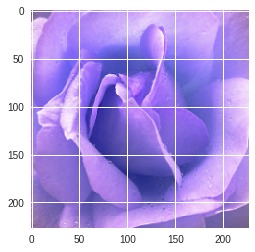

In [18]:
plt.imshow(data[0])
print (labels[0])

In [24]:
#convert lists to numpy arrays
data = np.asarray(data)
labels = np.asarray(labels)


#mapping of label to int values
label_mapping_dict = {}
count = 0
for element in np.unique(labels):
  label_mapping_dict[element] = count
  count += 1
  
print (label_mapping_dict)

#using mapping above, transform label to numeric values
labels = [label_mapping_dict[i] for i in labels]

#one hot encode the labels
labels = np.eye( len(np.unique(labels)) )[np.array(labels).reshape(-1)]

print (labels[0])

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}
[0. 0. 1. 0. 0.]


In [0]:
np.save('gdrive/My Drive/dataset', data)
np.save('gdrive/My Drive/labels', labels)

## EDA

In [26]:
dataset = np.load('gdrive/My Drive/dataset.npy')
labels = np.load('gdrive/My Drive/labels.npy')

print (labels.shape)
print (dataset.shape)

(4323, 5)
(4323, 227, 227, 3)


[0. 0. 1. 0. 0.]


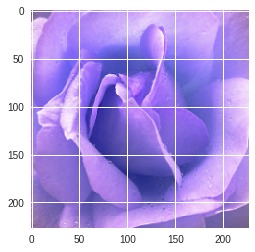

In [35]:
plt.imshow(dataset[0])
print (labels[0])

0 769


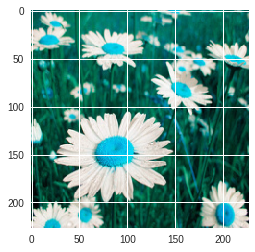

1 1052


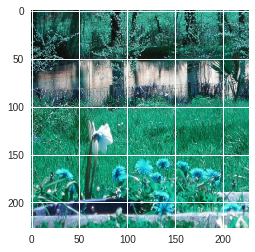

2 784


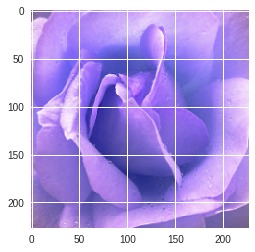

3 734


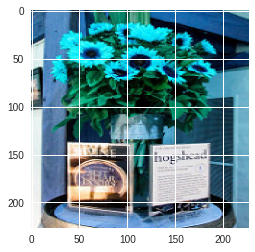

4 984


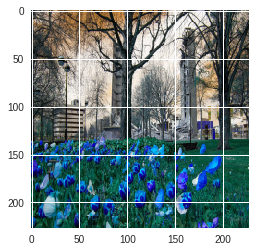

In [44]:
#distribution of classes
for i in range(labels.shape[1]):
  #count sum of occurence along y axis
  print (i, (labels.T[i] == 1.).sum() )
  
  # present first image of each class (inaccurate presentation because of colorspace issue b/w OpenCV and Matplotlib libraries)
  plt.imshow(dataset[ np.where(labels.T[i] == 1.)[0][0] ])
  plt.show()

## MODEL CREATION IN KERAS

In [0]:
#create generator for generating random data for each batch
def batch_iter(data, labels, batch_size, shuffle=True):
    num_batches_per_epoch = int((len(data) - 1) / batch_size) + 1

    def data_generator():
        data_size = len(data)
        while True:
            # Shuffle the data at each epoch
            if shuffle:
                shuffle_indices = np.random.permutation(np.arange(data_size))
                shuffled_data = data[shuffle_indices]
                shuffled_labels = labels[shuffle_indices]
            else:
                shuffled_data = data
                shuffled_labels = labels

            for batch_num in range(num_batches_per_epoch):
                start_index = batch_num * batch_size
                end_index = min((batch_num + 1) * batch_size, data_size)
                X, y = shuffled_data[start_index: end_index], shuffled_labels[start_index: end_index]
                yield X, y

    return num_batches_per_epoch, data_generator()

In [58]:
#Start with a pretrained model
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping

input_tensor = Input(shape=(227, 227, 3))
# create the base pre-trained model

base_model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(4096, activation='relu')(x)
x = Dropout(0.50)(x)
x = Dense(4096, activation='relu')(x)
x = Dropout(0.50)(x)

#5 neurons for 5 output classes
predictions = Dense(5, activation='softmax')(x)

batch_size = 128
epochs = 3 #obtained experimentally

model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional pretrained layers
for layer in base_model.layers:
    layer.trainable = False

#compile model
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics = ['accuracy']) #LR obtained experimentally

#split into train/val sets
X_train, X_val, y_train, y_val = train_test_split(dataset, labels, test_size = 0.2)

#generate train/val data from generator
train_steps, train_batches = batch_iter(X_train, y_train, batch_size)
valid_steps, valid_batches = batch_iter(X_val, y_val, batch_size)

#call fit generator in keras to start training
model.fit_generator(train_batches, train_steps, epochs, validation_data=valid_batches, validation_steps=valid_steps)

EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')


Epoch 1/3
28/28 [==============================] - 54s 2s/step - loss: 1.4284 - acc: 0.6689 - val_loss: 0.8546 - val_acc: 0.7746
Epoch 2/3
28/28 [==============================] - 52s 2s/step - loss: 0.6475 - acc: 0.8184 - val_loss: 0.7489 - val_acc: 0.7931
Epoch 3/3
28/28 [==============================] - 52s 2s/step - loss: 0.5989 - acc: 0.8257 - val_loss: 0.7105 - val_acc: 0.8069


In [0]:
# Save the weights
model.save('gdrive/My Drive/model_weights.h5')


In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 227, 227, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 227, 227, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 227, 227, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 113, 113, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 113, 113, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 113, 113, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

sunflower


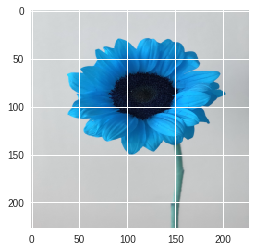

In [7]:
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

#load the model
model = load_model('gdrive/My Drive/model_weights.h5')

#resize and adjust the image
img = cv2.imread("gdrive/My Drive/temp.jpg")

img = cv2.resize(img, (227,227), interpolation=cv2.INTER_AREA)
plt.imshow(img)

img = img.reshape(-1, 227, 227, 3)

print ( class_names[ np.argmax(model.predict(img)) ] )
